## Importing the relevant libraries

In [ ]:
# # connect to google colab
# from google.colab import drive
# drive.mount("/content/drive")

In [2]:
# import all the necessary model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout, Lambda, Input, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# from keras import regularizers
from tensorflow.keras.models import Model, load_model

from IPython.display import display, Image
import time

#from tensorflow.keras.applications import Xception

In [3]:
# change colab flag to false if train using jupyter notebook else set to true if using colab
COLAB_FLAG = False

COLAB_FILEPATH = './drive/My Drive/4041-dog-breed-classification/' if COLAB_FLAG == True else './'
%matplotlib inline

In [4]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


## Import the numpy (.npz) file consisting our training images
* [np.save()](https://numpy.org/doc/stable/reference/generated/numpy.save.html)
* [np.savez()](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)
* [np.savez_compressed()](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html)
* [np.lib.format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)

In [5]:
INPUT_SHAPE = (299,299,3)
# NPZ_PATH = f'{COLAB_FILEPATH}Datasets/preprocessed_data_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'
NPZ_PATH = f'{COLAB_FILEPATH}Datasets/preprocessed_data_u{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}.npz'
print(NPZ_PATH)

./Datasets/preprocessed_data_u299x299.npz


In [6]:
# check the numpy array information and the size conversion
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def nparray_info(header, nparr):
    print(header)
    print("-  shape\t", nparr.shape)
    print("-  dtype\t", nparr.dtype)
    print("- nbytes\t", f"{nparr.nbytes} ({convert_size(nparr.nbytes)})")

In [7]:
# loading the npz file
import gc
print("Loading from npz file")
t = time.time()
loaded = np.load(NPZ_PATH)
print(loaded.files)
loaded_X = loaded["X"]
loaded_Y = loaded["Y"]
del loaded
gc.collect()

print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X', 'Y']
Time taken to load compressed data: 13.066611051559448


In [8]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X)
print()
nparray_info("Labels (npz)", loaded_Y)

Images (npz)
-  shape	 (10222, 299, 299, 3)
-  dtype	 uint8
- nbytes	 2741571066 (2.55 GB)

Labels (npz)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [9]:
# check the numpy array values whether is it normalised or not
# loaded_X[50][0][:7]

In [10]:
# loaded_Y[50]

In [11]:
# get the respective labels
# loading labels from csv file
df = pd.read_csv(f"{COLAB_FILEPATH}Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
breeds = sorted(df.breed.unique())
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


In [12]:
# dict_breeds

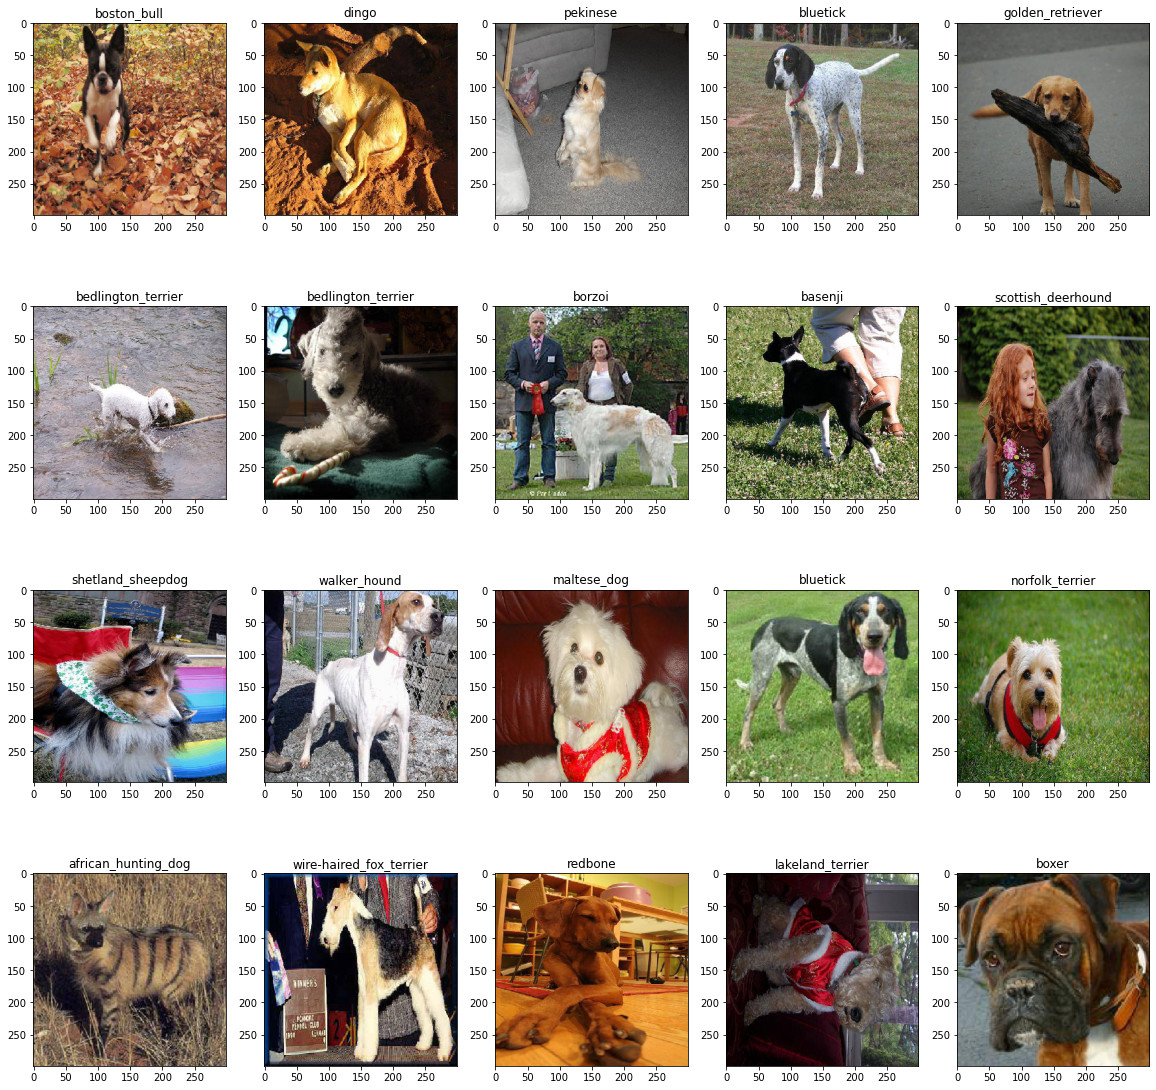

In [13]:
# # check the data
# N = 20

# plt.figure(figsize=(20,20))
# for i in range(N):
#     ax = plt.subplot(int(N/5),5,i+1)
#     plt.title(breeds[np.where(loaded_Y[i]==1)[0][0]])
#     if loaded_X.dtype==np.uint8:
#         plt.imshow(loaded_X[i])
#     else:
#         plt.imshow(loaded_X[i].astype('float32'))

## Image Augmentation

In [14]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = "nearest"
)

# --- MODEL BUILDING ---

In [15]:
# load the different pre-trained models
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201

In [16]:
def build_model():
    # pre-processing layer
    input_layer = Input(INPUT_SHAPE)
    preprocessor = Lambda(lambda x: x/255.0, name="preprocessor")(input_layer)
    base = Xception(include_top=False,weights="imagenet", input_shape=INPUT_SHAPE)(preprocessor)
    # rebuild output layer
    x = base
    x = GlobalAveragePooling2D()(x)
    head = Dense(120, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=head)
    return model
    
    

In [17]:
feature_extractor = build_model()
features = feature_extractor.predict(loaded_X, verbose=1)

320/320 [==============================] - 46s 108ms/step


In [19]:
print("image size", INPUT_SHAPE)
nparray_info("features", loaded_Y)

image size (299, 299, 3)
features
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [18]:
# features2 = feature_extractor.predict(train_datagen.flow(loaded_X,loaded_Y,batch_size=64,shuffle=True), verbose=1)